
=== THÔNG TIN DỮ LIỆU ===
- Số chiều ban đầu: 784 (28x28)
- Kích thước Train-split: 4000
- Kích thước Validation-split: 1000
- Kích thước Test set: 1000


=== Begining process K=10 ===
Giảm chiều từ 784 → 10 (giảm 98.7%)

[1/3] Processing NMF...

[2/3] Chuẩn hóa dữ liệu...

[3/3] Traning and evaluation KNN...

KẾT QUẢ K=10:
- Giảm chiều: 784 → 10 (giảm 98.7%)
- Thời gian: 21.3s
- Độ chính xác KNN (VAL): 0.7700
- Độ chính xác KNN (TEST - tham khảo): 0.8080
- Reconstruction error: 674.47


=== Begining process K=20 ===
Giảm chiều từ 784 → 20 (giảm 97.4%)

[1/3] Processing NMF...

[2/3] Chuẩn hóa dữ liệu...

[3/3] Traning and evaluation KNN...

KẾT QUẢ K=20:
- Giảm chiều: 784 → 20 (giảm 97.4%)
- Thời gian: 24.7s
- Độ chính xác KNN (VAL): 0.8640
- Độ chính xác KNN (TEST - tham khảo): 0.8780
- Reconstruction error: 601.31


=== Begining process K=30 ===
Giảm chiều từ 784 → 30 (giảm 96.2%)

[1/3] Processing NMF...

[2/3] Chuẩn hóa dữ liệu...

[3/3] Traning and evaluation KNN...

KẾT QUẢ K=3

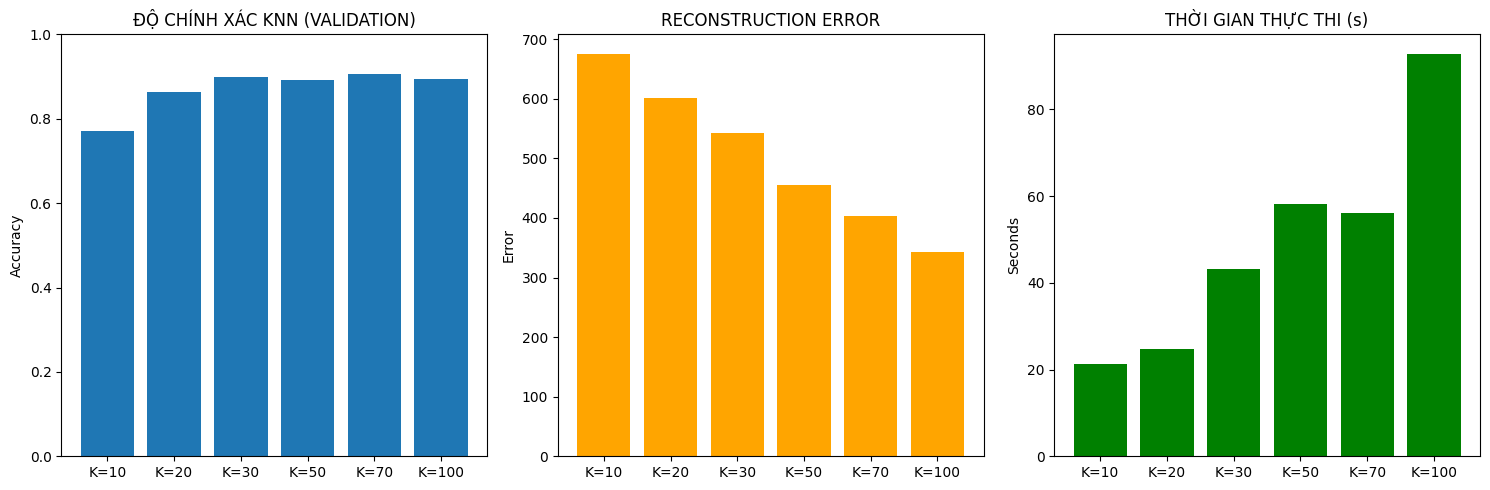


=== KẾT QUẢ TỐT NHẤT (chọn theo VALIDATION) ===
K tối ưu: K=70
- VAL Accuracy: 0.9050
- TEST Accuracy (tham khảo): 0.9080
- Giảm chiều: 784 → 70 (giảm 91.1%)
- Thời gian xử lý: 56.1s
- Reconstruction error: 403.82

=== ĐÁNH GIÁ CUỐI CÙNG TRÊN TEST (sau khi chọn k bằng VALIDATION) ===
k* = 70 | TEST Accuracy (final) = 0.9060 | Recon err (train_full) = 447.84


In [4]:
import numpy as np
from keras.datasets import mnist
from sklearn.decomposition import NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time

# === (THÊM): tách validation từ tập train để chọn k ===
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# 1. DOWNLOAD DATASET FROM MNIST
(x_train_full, y_train_full), (x_test_full, y_test_full) = mnist.load_data()

np.random.seed(42)
train_idx = np.random.choice(len(x_train_full), 5000, replace=False)
test_idx = np.random.choice(len(x_test_full), 1000, replace=False)

x_train = x_train_full[train_idx]
y_train = y_train_full[train_idx]
x_test = x_test_full[test_idx]
y_test = y_test_full[test_idx]

# 2. DATA INFORMATION
# Tính số chiều ban đầu của dữ liệu (28x28 pixel cho ảnh MNIST)
original_dim = x_train.shape[1] * x_train.shape[2]  # 28*28 = 784

# print("\n=== THÔNG TIN DỮ LIỆU ===")
# print(f"- Số chiều ban đầu: {original_dim} (28x28)")
# print(f"- Kích thước tập train: {x_train.shape[0]} mẫu")
# print(f"- Kích thước tập test: {x_test.shape[0]} mẫu")

# 3. TIỀN XỬ LÝ
# Chuyển đổi ảnh 2D (28x28) thành vector 1D (784) và chuẩn hóa giá trị pixel về [0, 1]
x_train_flat = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test_flat = x_test.reshape(x_test.shape[0], -1) / 255.0

# === (THÊM): tách validation từ TRAIN để chọn k, tránh dùng TEST ===
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, val_idx = next(sss.split(x_train_flat, y_train))
x_tr_flat, y_tr = x_train_flat[tr_idx], y_train[tr_idx]
x_val_flat, y_val = x_train_flat[val_idx], y_train[val_idx]

print("\n=== THÔNG TIN DỮ LIỆU ===")
print(f"- Số chiều ban đầu: {original_dim} (28x28)")
print(f"- Kích thước Train-split: {x_tr_flat.shape[0]}")
print(f"- Kích thước Validation-split: {x_val_flat.shape[0]}")
print(f"- Kích thước Test set: {x_test_flat.shape[0]}")

# 4. THỬ NGHIỆM VỚI CÁC GIÁ TRỊ K (số thành phần trong NMF)
k_values = [10, 20, 30, 50, 70, 100]
results = []

for k in k_values:
    print(f"\n\n=== Begining process K={k} ===")
    print(f"Giảm chiều từ {original_dim} → {k} (giảm {(1 - k/original_dim)*100:.1f}%)")

    start_time = time.time()  # Bắt đầu đếm thời gian

    # 4.1. GIẢM CHIỀU VỚI NMF
    print("\n[1/3] Processing NMF...")
    # Tạo mô hình NMF với các tham số:
    # - n_components=k: số thành phần cần trích xuất
    # - init='nndsvda': phương pháp khởi tạo tốt cho dữ liệu thưa
    # - max_iter=500: tăng số lần lặp tối đa để đảm bảo hội tụ
    # - random_state=42: đảm bảo kết quả có thể tái lập
    # - solver='mu': giải thuật cập nhật nhân (phù hợp với KL divergence)
    # - beta_loss='kullback-leibler': độ đo loss phù hợp cho dữ liệu ảnh
    nmf = NMF(n_components=k,
              init='nndsvda',
              max_iter=500,
              random_state=42,
              solver='mu',
              beta_loss='kullback-leibler')

    # Áp dụng NMF cho tập train và transform tập test
    train_nmf = nmf.fit_transform(x_tr_flat)
    val_nmf = nmf.transform(x_val_flat)
    test_nmf = nmf.transform(x_test_flat)

    # 4.2. CHUẨN HÓA DỮ LIỆU CHO KNN
    print("\n[2/3] Chuẩn hóa dữ liệu...")
    # KNN nhạy cảm với tỷ lệ giữa các đặc trưng nên cần chuẩn hóa
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    train_nmf_scaled = scaler.fit_transform(train_nmf)  # Chuẩn hóa tập train
    val_nmf_scaled = scaler.transform(val_nmf)
    test_nmf_scaled = scaler.transform(test_nmf)        # Áp dụng cùng chuẩn hóa cho tập test

    # 4.3. XÂY DỰNG VÀ ĐÁNH GIÁ KNN
    print("\n[3/3] Traning and evaluation KNN...")
    # Tạo mô hình KNN
    knn = KNeighborsClassifier(n_neighbors=5)

    # Huấn luyện mô hình trên dữ liệu đã giảm chiều và chuẩn hóa
    knn.fit(train_nmf_scaled, y_tr)

    # Dự đoán nhãn cho VALIDATION và TEST
    y_val_pred = knn.predict(val_nmf_scaled)
    y_test_pred = knn.predict(test_nmf_scaled)         # giữ phép đo test để hiển thị

    # accuracy
    val_accuracy = accuracy_score(y_val, y_val_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Store result to list
    exec_time = time.time() - start_time  # Tính thời gian thực thi
    results.append({
        'k': k,
        'original_dim': original_dim,
        'reduced_dim': k,
        'reduction_ratio': f"{(1 - k/original_dim)*100:.1f}%",
        'time': exec_time,
        'error': nmf.reconstruction_err_,  # Sai số tái tạo của NMF
        'acc': test_accuracy,              # (giữ trường 'acc' như cũ để không phá vỡ code in/plot)
        'val_acc': val_accuracy            # độ chính xác trên validation để CHỌN k
    })

    print(f"\nKẾT QUẢ K={k}:")
    print(f"- Giảm chiều: {original_dim} → {k} (giảm {(1 - k/original_dim)*100:.1f}%)")
    print(f"- Thời gian: {exec_time:.1f}s")
    print(f"- Độ chính xác KNN (VAL): {val_accuracy:.4f}")
    print(f"- Độ chính xác KNN (TEST - tham khảo): {test_accuracy:.4f}")
    print(f"- Reconstruction error: {results[-1]['error']:.2f}")

# Summary
print("\n\n=== Summary Report ===")
print(f"{'K':<5} | {'Giảm chiều':<15} | {'Thời gian':<10} | {'VAL Acc':<10} | {'TEST Acc':<10} | {'Recon Error':<12}")
print("-" * 65)
for res in results:
    print(f"{res['k']:<5} | {res['original_dim']}→{res['reduced_dim']} ({res['reduction_ratio']}) | {res['time']:<10.1f} | {res['val_acc']:<10.4f} | {res['acc']:<10.4f} | {res['error']:<12.2f}")  # <-- ĐÃ SỬA

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar([f"K={res['k']}" for res in results], [res['val_acc'] for res in results])
plt.title('ĐỘ CHÍNH XÁC KNN (VALIDATION)')
plt.ylim(0, 1.0)  # Giới hạn trục y từ 0-100% accuracy
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.bar([f"K={res['k']}" for res in results], [res['error'] for res in results], color='orange')
plt.title('RECONSTRUCTION ERROR')
plt.ylabel('Error')

plt.subplot(1, 3, 3)
plt.bar([f"K={res['k']}" for res in results], [res['time'] for res in results], color='green')
plt.title('THỜI GIAN THỰC THI (s)')
plt.ylabel('Seconds')

plt.tight_layout()
plt.show()

# Fine the best K
best = max(results, key=lambda x: x['val_acc'])
print("\n=== KẾT QUẢ TỐT NHẤT (chọn theo VALIDATION) ===")
print(f"K tối ưu: K={best['k']}")
print(f"- VAL Accuracy: {best['val_acc']:.4f}")
print(f"- TEST Accuracy (tham khảo): {best['acc']:.4f}")
print(f"- Giảm chiều: {best['original_dim']} → {best['reduced_dim']} (giảm {best['reduction_ratio']})")
print(f"- Thời gian xử lý: {best['time']:.1f}s")
print(f"- Reconstruction error: {best['error']:.2f}")

# === (THÊM - khuyến nghị chuẩn): Huấn luyện lại với k* trên toàn bộ TRAIN (train+val), rồi đánh giá TEST một lần ===
k_star = best['k']
nmf_final = NMF(n_components=k_star, init='nndsvda', max_iter=500, random_state=42, solver='mu',
                beta_loss='kullback-leibler')
H_train_full = nmf_final.fit_transform(x_train_flat)
H_test_full = nmf_final.transform(x_test_flat)

scaler_final = StandardScaler()
H_train_full_sc = scaler_final.fit_transform(H_train_full)
H_test_full_sc = scaler_final.transform(H_test_full)

knn_final = KNeighborsClassifier(n_neighbors=5)
knn_final.fit(H_train_full_sc, y_train)
y_test_final = knn_final.predict(H_test_full_sc)
test_acc_final = accuracy_score(y_test, y_test_final)

print("\n=== ĐÁNH GIÁ CUỐI CÙNG TRÊN TEST (sau khi chọn k bằng VALIDATION) ===")
print(f"k* = {k_star} | TEST Accuracy (final) = {test_acc_final:.4f} | Recon err (train_full) = {nmf_final.reconstruction_err_:.2f}")


=== MINH HỌA PHÂN TÍCH V ≈ W.H ===
Ảnh được chọn: Index 34, Label: Two


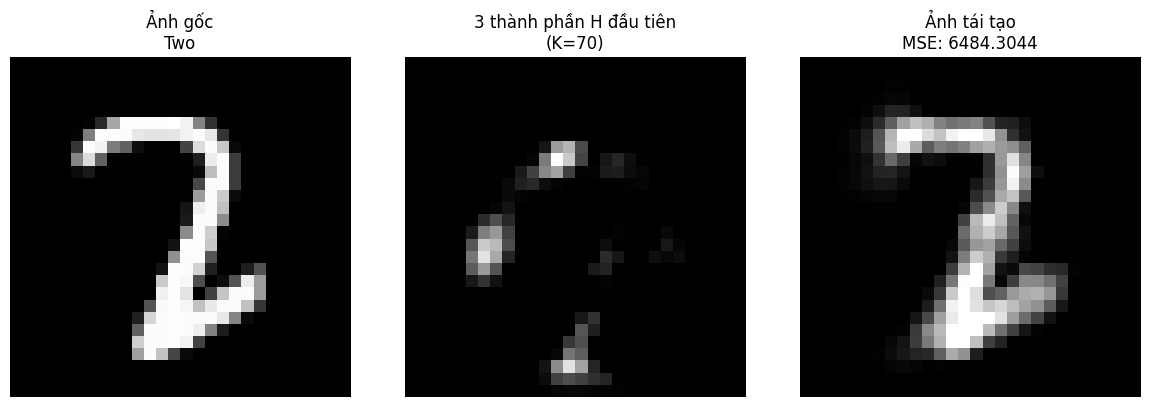


THÔNG SỐ KỸ THUẬT:
- Kích thước W: (1, 70)
- Kích thước H: (70, 784)
- Reconstruction error: 342.06


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

# 0. ĐỊNH NGHĨA NHÃN CHO MNIST (0-9)
label_dict = {
    0: 'Zero',
    1: 'One',
    2: 'Two',
    3: 'Three',
    4: 'Four',
    5: 'Five',
    6: 'Six',
    7: 'Seven',
    8: 'Eight',
    9: 'Nine'
}

# 1. CHỌN NGẪU NHIÊN 1 ẢNH TỪ TẬP TEST
random_idx = np.random.randint(0, len(x_test))
V_original = x_test[random_idx].reshape(28, 28)  # Ảnh gốc (28, 28)
V_flat = x_test_flat[random_idx]  # Vector flatten (784,)

print("\n=== MINH HỌA PHÂN TÍCH V ≈ W.H ===")
print(f"Ảnh được chọn: Index {random_idx}, Label: {label_dict[y_test[random_idx]]}")

# 2. PHÂN TÍCH THÀNH W VÀ H (dùng NMF đã huấn luyện trước đó)
W_single = nmf_final.transform(V_flat.reshape(1, -1))  # Shape: (1, K)
H = nmf_final.components_  # Shape: (K, 784)

# 3. TÁI TẠO ẢNH: V_reconstructed = W.H
V_reconstructed = np.dot(W_single, H).reshape(28, 28)
V_reconstructed = np.clip(V_reconstructed, 0, 1)  # Đảm bảo giá trị pixel [0,1]

# 4. HIỂN THỊ KẾT QUẢ
plt.figure(figsize=(12, 4))

# Ảnh gốc (grayscale)
plt.subplot(1, 3, 1)
plt.imshow(V_original, cmap='gray')
plt.title(f"Ảnh gốc\n{label_dict[y_test[random_idx]]}")
plt.axis('off')

# Thành phần H (3 components đầu)
plt.subplot(1, 3, 2)
component_vis = np.zeros((28, 28))
for i in range(3):  # Lấy 3 components đầu
    comp = H[i].reshape(28, 28)
    comp = (comp - comp.min()) / (comp.max() - comp.min())  # Chuẩn hóa
    component_vis += comp
plt.imshow(component_vis / 3, cmap='gray')
plt.title(f"3 thành phần H đầu tiên\n(K={nmf_final.n_components})")
plt.axis('off')

# Ảnh tái tạo (grayscale)
plt.subplot(1, 3, 3)
plt.imshow(V_reconstructed, cmap='gray')
plt.title(f"Ảnh tái tạo\nMSE: {np.mean((V_original - V_reconstructed)**2):.4f}")
plt.axis('off')

plt.tight_layout()
plt.show()

# 5. THÔNG TIN KỸ THUẬT
print("\nTHÔNG SỐ KỸ THUẬT:")
print(f"- Kích thước W: {W_single.shape}")
print(f"- Kích thước H: {H.shape}")
print(f"- Reconstruction error: {nmf.reconstruction_err_:.2f}")


=== KẾT QUẢ PHÂN LOẠI CHI TIẾT ===

BÁO CÁO PHÂN LOẠI:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        98
           1       0.90      1.00      0.95       115
           2       0.97      0.90      0.93       107
           3       0.86      0.93      0.89        86
           4       0.89      0.93      0.91        85
           5       0.86      0.82      0.84        84
           6       0.93      0.93      0.93       106
           7       0.90      0.94      0.92       104
           8       0.96      0.79      0.86       113
           9       0.91      0.84      0.87       102

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.90      1000
weighted avg       0.91      0.91      0.91      1000



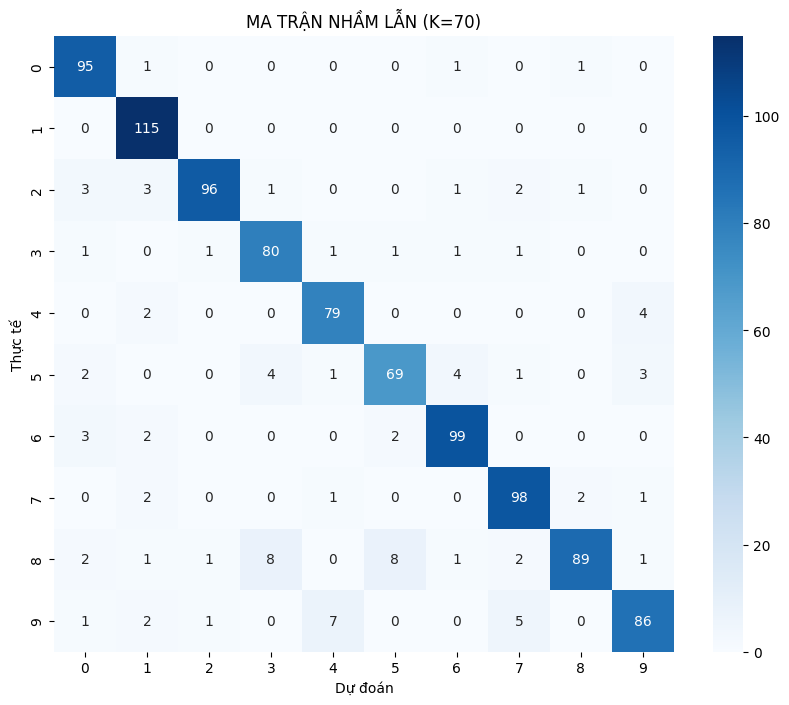


VÍ DỤ MẪU PHÂN LOẠI ĐÚNG VÀ SAI:


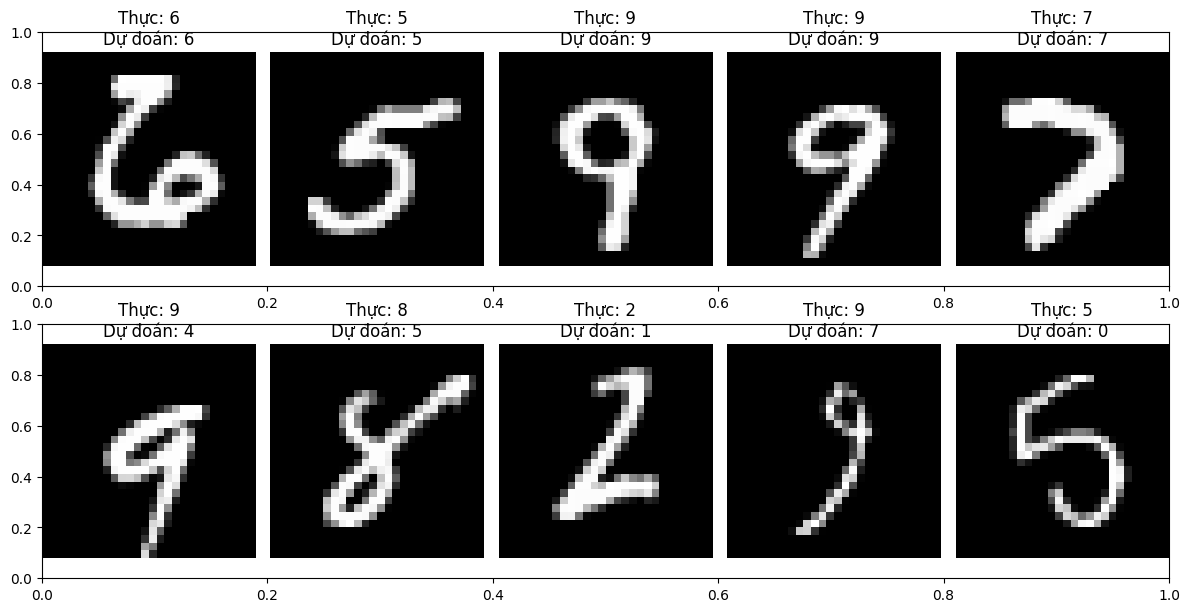

In [6]:
# 8. HIỂN THỊ KẾT QUẢ PHÂN LOẠI CHI TIẾT CHO K TỐT NHẤT
print("\n=== KẾT QUẢ PHÂN LOẠI CHI TIẾT ===")

# Lấy lại mô hình NMF và KNN cho k tốt nhất
nmf_best = NMF(n_components=best['k'],
              init='nndsvda',
              max_iter=500,
              random_state=42,
              solver='mu',
              beta_loss='kullback-leibler')
train_nmf_best = nmf_best.fit_transform(x_train_flat)
test_nmf_best = nmf_best.transform(x_test_flat)

scaler_best = StandardScaler()
train_nmf_scaled_best = scaler_best.fit_transform(train_nmf_best)
test_nmf_scaled_best = scaler_best.transform(test_nmf_best)

knn_best = KNeighborsClassifier(n_neighbors=5)
knn_best.fit(train_nmf_scaled_best, y_train)

# Dự đoán trên tập test
y_pred = knn_best.predict(test_nmf_scaled_best)

# 8.1. REPORT PHÂN LOẠI
from sklearn.metrics import classification_report
print("\nBÁO CÁO PHÂN LOẠI:")
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(10)]))

# 8.2. MA TRẬN NHẦM LẪN
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10),
            yticklabels=range(10))
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title(f'MA TRẬN NHẦM LẪN (K={best["k"]})')
plt.show()

# 8.3. VÍ DỤ MẪU ĐÚNG/SAI
print("\nVÍ DỤ MẪU PHÂN LOẠI ĐÚNG VÀ SAI:")
correct_samples = []
wrong_samples = []

for i in range(len(y_test)):
    if y_test[i] == y_pred[i] and len(correct_samples) < 5:
        correct_samples.append(i)
    elif y_test[i] != y_pred[i] and len(wrong_samples) < 5:
        wrong_samples.append(i)
    if len(correct_samples) >= 5 and len(wrong_samples) >= 5:
        break

# Hiển thị ảnh
plt.figure(figsize=(12, 6))

# Mẫu đúng
plt.subplot(2, 1, 1)
# plt.title("MẪU PHÂN LOẠI ĐÚNG")
for i, idx in enumerate(correct_samples):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"Thực: {y_test[idx]}\nDự đoán: {y_pred[idx]}")
    plt.axis('off')

# Mẫu sai
plt.subplot(2, 1, 2)
# plt.title("MẪU PHÂN LOẠI SAI")
for i, idx in enumerate(wrong_samples):
    plt.subplot(2, 5, i+6)
    plt.imshow(x_test[idx], cmap='gray')
    plt.title(f"Thực: {y_test[idx]}\nDự đoán: {y_pred[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()